In [1]:
import os
import pandas as pd 
import numpy as np
from tqdm import tqdm
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_ind_from_stats

# Import pakages for machine learning
from sklearn.linear_model import LogisticRegression 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import lightgbm as lgb

# Deep neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout

## 0. Preprocess simple PHS files

> define `is_all_time` == True of False

> if `is_all_time` == False, then specify `phs_name = phs_list[#]`

> add `is_match_winner` and `is_map_winner` features into the dataframe

In [49]:
# File path of prepared new_phs
path = "./data/"
phs_list = os.listdir(path)
phs_list = [file_name for file_name in phs_list if file_name.endswith(".csv")]
phs_list = phs_list[1:] # remove new_match_map_stats.csv from the list

# choose all time or specific season
is_all_time = True # set True if target data is all seasons data

if is_all_time == True:
    li = []
    for phs_name in phs_list:
        new_phs = pd.read_csv(f'{path}{phs_name}')
        li.append(new_phs)
    new_phs = pd.concat(li, axis=0, ignore_index=True)
    all_seasons = True

else:
    phs_name = phs_list[11] # set index of target csv file
    print(f'selected phs: {phs_name}')
    new_phs = pd.read_csv(f'{path}{phs_name}')
    all_seasons = False

new_phs['team_DI'] = new_phs[new_phs['team_name'] == new_phs['team_one_name']]['team_one_DI']
new_phs['team_DI'].fillna(new_phs['team_two_DI'], inplace=True)

# select season
is_select_season = True # set True for selecting season
if is_select_season == True: 
    select_season=2020
    new_phs = new_phs[new_phs['season']==select_season]

## 1. Feature Engineering

> Define a `target_hero = All Heroes`

> remove features by `remove_feature`

> specify the data type `X, y = data_type[#]` among 0:'real', 1:'norm', 2:'10min avg'

In [50]:
# data collection
df = new_phs[['esports_match_id', 'player_name', 'team_name', 'map_name', 'stat_name', 'hero_name', 'stat_amount', 'team_DI', 'is_map_winner']]

# select target hero
'''
양팀 모두 같은 영웅을 쓴 것 아니면 normalize 에서 같이 비교하기 힘들다
'''
target_hero = 'Mercy' # put 'All Heroes' for selecting all heroes

# data selection
df = df[df['hero_name'] == target_hero]
df = df.groupby(['esports_match_id', 'team_name', 'map_name', 'stat_name'])[['stat_amount', 'is_map_winner', 'team_DI']].mean()
df = df.unstack()

# drop if time played is below than `min_play_time` per map
min_play_time = 180 # set minimum play time to make a cut
df = df[df[('stat_amount','Time Played')] > min_play_time]

# get `is_map_winner`
is_map_winner = df[('is_map_winner', 'Time Played')]
is_map_winner.rename('is_map_winner', inplace=True)

# get team_DI
team_DI = df[('team_DI', 'Time Played')]
team_DI.fillna(0.5, inplace=True) # replace nan to 0.5. `there was 2 nan values in whole owl season data`
team_DI.rename('team_DI', inplace=True)

# check nan value
print(f'num of nan in is_map_winner: {is_map_winner.isna().sum()}')
print(f'len of is_map_winner: {len(is_map_winner)}')
print(f'num of nan in team_DI: {team_DI.isna().sum()}')
print(f'len of team_DI: {len(team_DI)}')

# engineer stats
df.drop(('is_map_winner',), axis=1, inplace=True) # drop is_map_winner column and leave only stat
df.drop(('team_DI',), axis=1, inplace=True) # drop team_DI column and leave only stat
df = df.xs('stat_amount', level=0, axis=1) # drop multilevel index

# Remove irrelevant features
remove_feature = ['Average Time Alive', 'Damage Done', 'Knockback Kills', 'Teleporter Pads Destroyed', 'Time Alive', 'Turrets Destroyed', 'Ultimates Earned - Fractional'] # Always remove these features
common_stats = ['Deaths', 'Final Blows', 'Objective Time', 'Assists', 'Objective Kills', 'All Damage Done', 'Melee Percentage of Final Blows', 'Hero Damage Done', 'Melee Final Blows', 'Ultimates Used', 'Healing Done', 'Defensive Assists', 'Barrier Damage Done', 'Shots Fired', 'Weapon Accuracy', 'Multikills', 'Time Building Ultimate', 'Solo Kills', 'Time Holding Ultimate', 'Damage Blocked', 'Damage - Quick Melee', 'Time Elapsed per Ultimate Earned', 'Offensive Assists', 'Environmental Kills', 'Environmental Deaths', 'Recon Assists', 'Eliminations', 'Damage Taken'] # Stats of 'All Heroes'
if target_hero != 'All Heroes':
    remove_feature.extend(common_stats) # remove common feature if target hero is not All Heroes

df = df[df.columns.difference(remove_feature)]

# data cleansing
df.fillna(0, inplace=True)
print(f'num of nan in df: {df.isna().sum().sum()}')
print(f'len of df: {df.shape[0]}')

# normalize to 10 min average
df_10min = df[df.columns.difference(['is_map_winner', 'team_DI'])].div(df['Time Played'], axis=0) * 600 # 10 min avg
print(f'num nan values in df_10min: {df_10min.isna().sum().sum()}')
print(f'len of df_10min: {df_10min.shape[0]}')

num of nan in is_map_winner: 0
len of is_map_winner: 464
num of nan in team_DI: 0
len of team_DI: 464
num of nan in df: 0
len of df: 464
num nan values in df_10min: 0
len of df_10min: 464


In [51]:
# Hero color
hero_hex_color = {'Ana':'#718ab3', 'Bastion':'#7c8f7b', 'Brigitte':'#be736e', 'D.Va':'#ed93c7', 'Doomfist':'#815049', 'Genji':'#97ef43', 'Hanzo':'#b9b48a', 'Junkrat':'#ecbd53', 'Lúcio':'#85c952', 'McCree':'#ae595c', 'Mei':'#6faced', 'Mercy':'#ebe8bb', 'Moira':'#803c51', 'Orisa':'#468c43', 'Pharah':'#3e7dca', 'Reaper':'#7d3e51', 'Reinhardt':'#929da3', 'Roadhog':'#b68c52', 'Soldier: 76':'#697794', 'Sombra':'#7359ba', 'Symmetra':'#8ebccc', 'Torbjörn':'#c0726e', 'Tracer':'#d79342', 'Widowmaker':'#9e6aa8', 'Winston':'#a2a6bf', 'Zarya':'#e77eb6', 'Zenyatta':'#ede582'}

In [52]:
# color owl team colors
import pickle

with open('owl_colors.pickle', 'rb') as fr:
    owl_colors = pickle.load(fr)

owl_colors_dict = {}

for team in owl_colors.keys():
    fullName = owl_colors[team]['fullName']
    mainColor = owl_colors[team]['secondaryColor'] # get main team color here
    color_in_hex = owl_colors[team]['colors'][mainColor]['hex']
    print(fullName, mainColor, color_in_hex)
    owl_colors_dict.update({fullName:color_in_hex})

owl_colors_dict

Dallas Fuel strongBlue #0072CE
Atlanta Reign darkRed #910F1B
Boston Uprising yellow #EFDF00
Chengdu Hunters lightBrown #B4926A
Florida Mayhem pink #CF4691
Los Angeles Gladiators black #000000
Guangzhou Charge darkCyan #67A2B2
Houston Outlaws green #97D700
Hangzhou Spark blue #5788CE
London Spitfire orange #FF8200
New York Excelsior blue #0F57EA
Paris Eternal darkPink #8D042D
Philadelphia Fusion gray #DCDCDC
Seoul Dynasty gold #AA8A00
San Francisco Shock gray #A5ACAF
Shanghai Dragons black #000000
Toronto Defiant red #C10021
Los Angeles Valiant yellow #FFD100
Vancouver Titans green #2FB228
Washington Justice darkBlue #003768


{'Dallas Fuel': '#0072CE',
 'Atlanta Reign': '#910F1B',
 'Boston Uprising': '#EFDF00',
 'Chengdu Hunters': '#B4926A',
 'Florida Mayhem': '#CF4691',
 'Los Angeles Gladiators': '#000000',
 'Guangzhou Charge': '#67A2B2',
 'Houston Outlaws': '#97D700',
 'Hangzhou Spark': '#5788CE',
 'London Spitfire': '#FF8200',
 'New York Excelsior': '#0F57EA',
 'Paris Eternal': '#8D042D',
 'Philadelphia Fusion': '#DCDCDC',
 'Seoul Dynasty': '#AA8A00',
 'San Francisco Shock': '#A5ACAF',
 'Shanghai Dragons': '#000000',
 'Toronto Defiant': '#C10021',
 'Los Angeles Valiant': '#FFD100',
 'Vancouver Titans': '#2FB228',
 'Washington Justice': '#003768'}

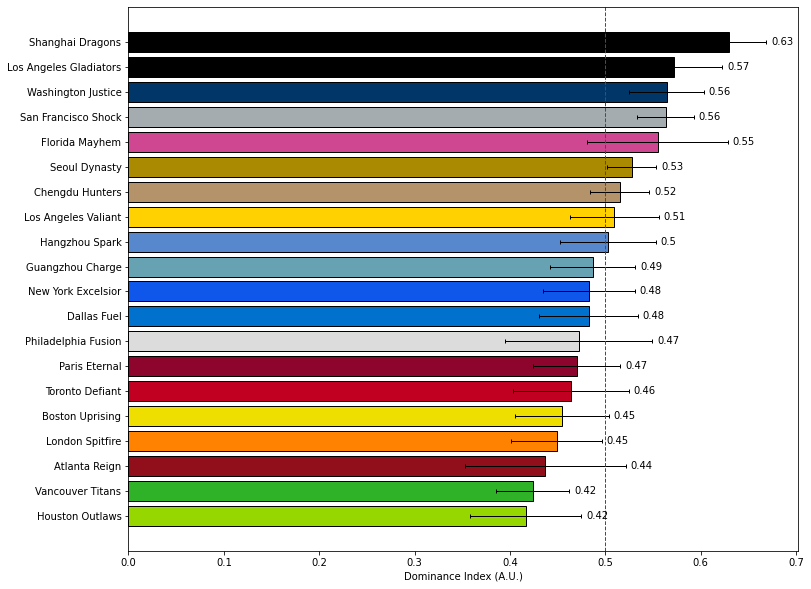

In [53]:
team_rank_df = pd.concat([df, team_DI], axis=1)

team_rank_df = team_rank_df.groupby(by='team_name')['team_DI'].agg(['mean', 'std', 'sem'])
team_rank_df = team_rank_df.sort_values(by='mean', ascending=True)
team_rank_df['color'] = team_rank_df.index.map(owl_colors_dict)
# display(team_rank_df)

plt.figure(figsize=(12,10))
plt.barh(team_rank_df.index.values, team_rank_df['mean'], color=team_rank_df['color'], edgecolor='black', xerr=team_rank_df['sem'], error_kw={'ecolor':'black', 'elinewidth':1, 'capsize':2})
plt.axvline(0.5, 0, 1, color='red', linestyle='--', linewidth=1) # add vertical line on DI=0.5
for i in team_rank_df.index:
    plt.text(team_rank_df.loc[i, 'mean']+team_rank_df.loc[i, 'sem']+0.005, i, round(team_rank_df.loc[i, 'mean'], 2), horizontalalignment='left', verticalalignment='center')

plt.xlabel('Dominance Index (A.U.)')

plt.show()

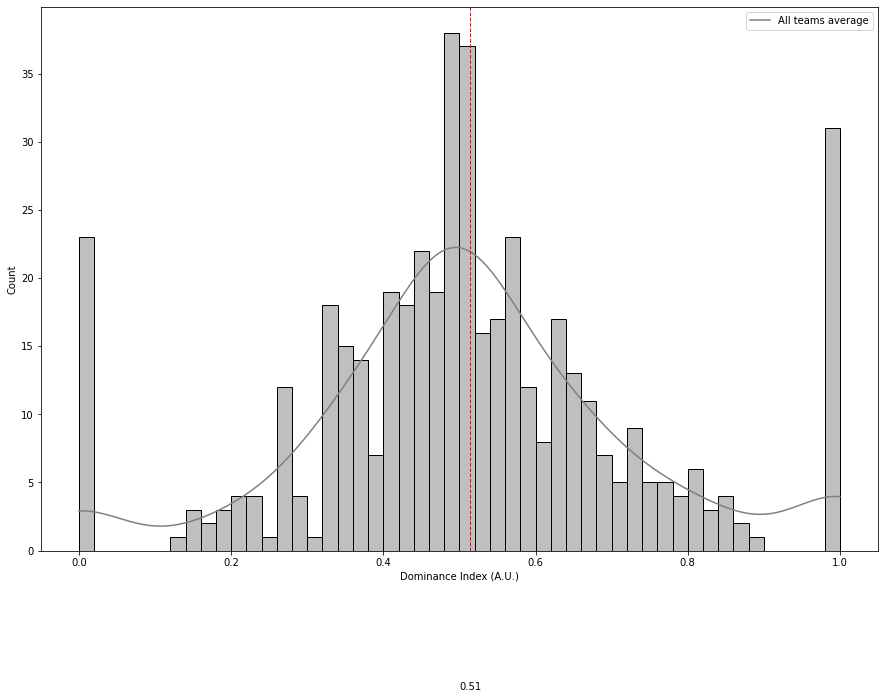

In [54]:
# plot all team's average DI distribution
team_rank_df_by_time = pd.concat([df, team_DI], axis=1)
fig, ax = plt.subplots(figsize=(15,10))
sns.histplot(data=team_rank_df_by_time, x='team_DI', kde=True, color='gray', bins=50)
plt.axvline(team_rank_df_by_time['team_DI'].mean(), 0, 1, linewidth=1, color='red', linestyle='--') # mark avg line
plt.text(team_rank_df_by_time['team_DI'].mean(), -10, round(team_rank_df_by_time['team_DI'].mean(), 2), horizontalalignment='center', verticalalignment='center') # avg value
plt.xlabel('Dominance Index (A.U.)')
plt.legend(['All teams average'])

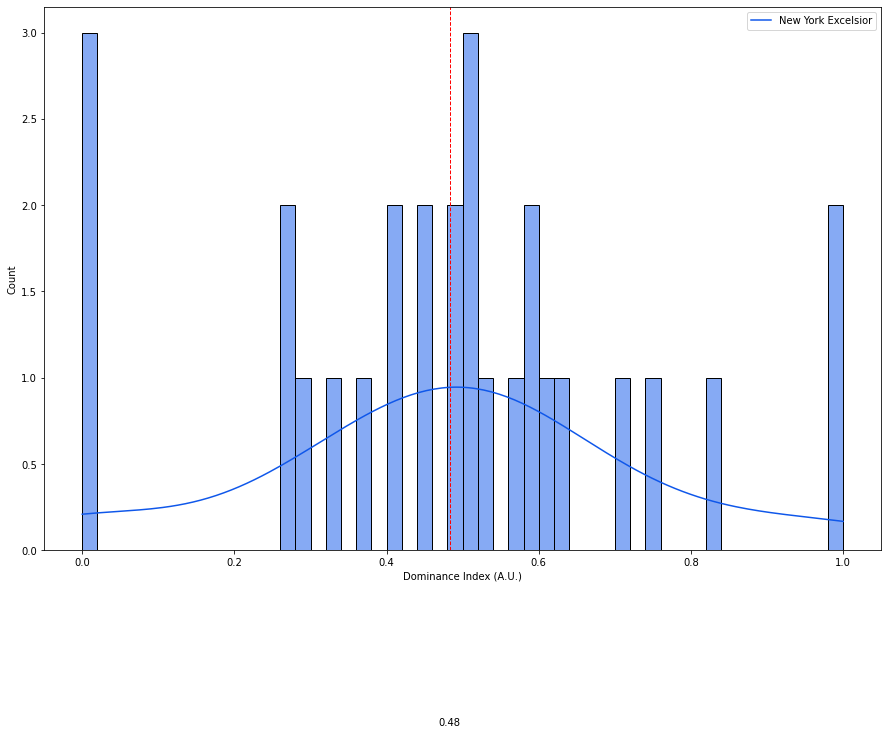

In [55]:
# plot team's DI distribution
target_team = 'New York Excelsior'
team_rank_df_by_time = pd.concat([df, team_DI], axis=1)
f = team_rank_df_by_time.xs(target_team, level='team_name')
fig, ax = plt.subplots(figsize=(15,10))
sns.histplot(data=f, x='team_DI', kde=True, ax=ax, color=owl_colors_dict[target_team], bins=50)
plt.axvline(f['team_DI'].mean(), 0, 1, linewidth=1, color='red', linestyle='--') # mark avg line
plt.text(f['team_DI'].mean(), -1, round(f['team_DI'].mean(), 2), horizontalalignment='center', verticalalignment='center') # avg value
plt.xlabel('Dominance Index (A.U.)')
plt.legend([target_team])

(0.0, 1.0)

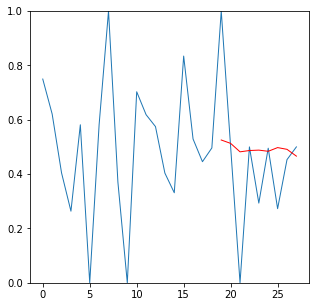

In [56]:
# plot team's DI history
team_rank_df_by_time = pd.concat([df, team_DI], axis=1)
f = team_rank_df_by_time.xs('New York Excelsior', level='team_name')
x = np.arange(0,len(f))
plt.figure(figsize=(5,5))
plt.plot(x, f['team_DI'], linewidth=1)

# smoothing by moving window method
window = f['team_DI'].rolling(window=20)
y_smooth = window.mean()
# plt.figure(figsize=(5,5))
plt.plot(x, y_smooth, 'r', linewidth=1)
plt.ylim(0,1)

## Data Transform

In [57]:
# Data Transform
X_real = df
y_real = team_DI

X_10min = df_10min
y_10min = team_DI
# Select X, y data type
'''
0: real
1: 10min
'''
# save data type here
data_type = []
data_type.append([X_real, y_real])
data_type.append([X_10min, y_10min])

X, y = data_type[1] # select data type with index
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

# Set train, validation and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

feature_names = X_train.columns

# Normalize the value with StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X shape: (464, 22)
y shape: (464,)
(371, 22) (93, 22) (371,) (93,)


## 2. Data Analysis

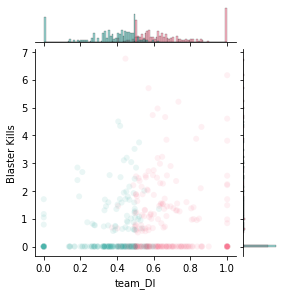

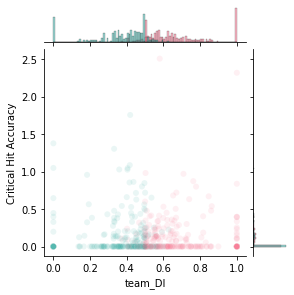

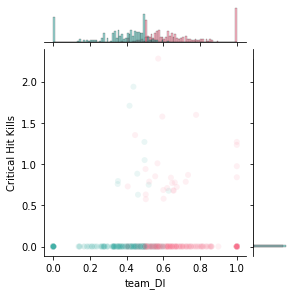

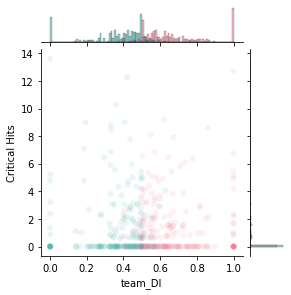

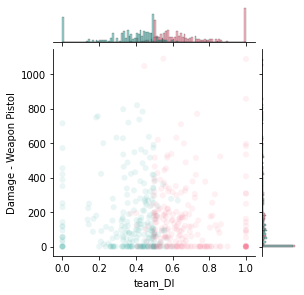

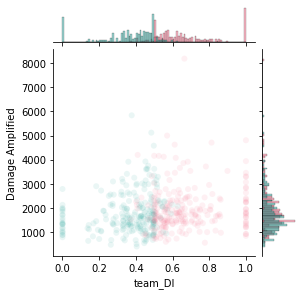

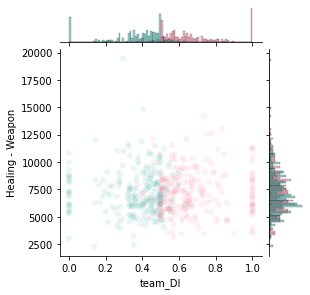

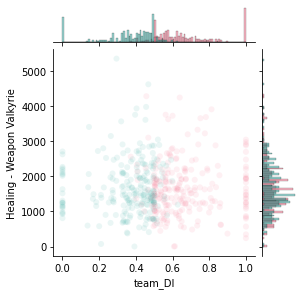

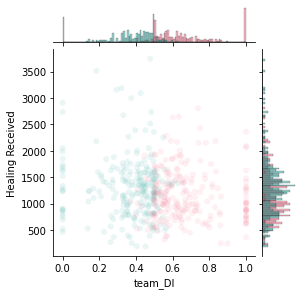

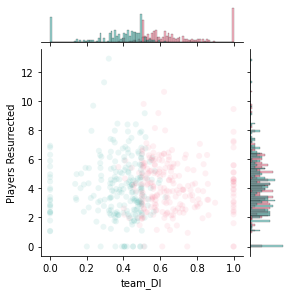

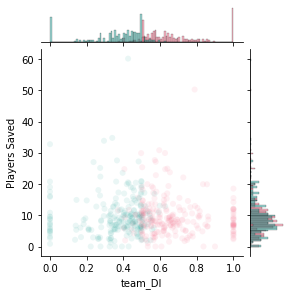

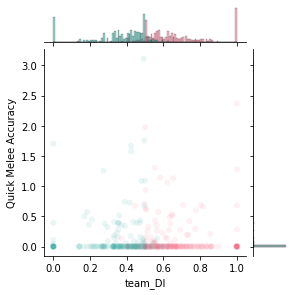

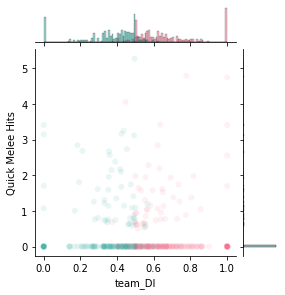

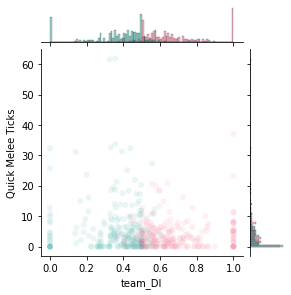

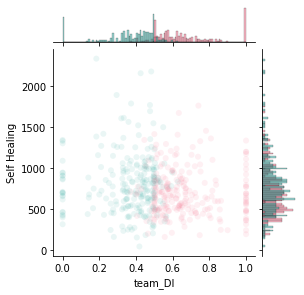

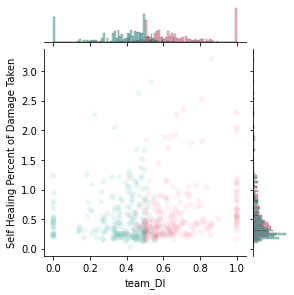

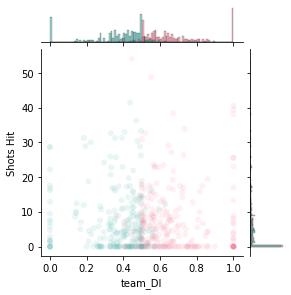

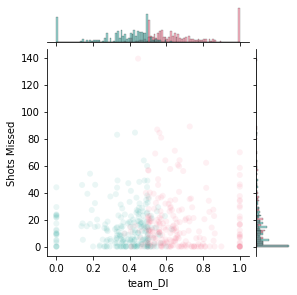

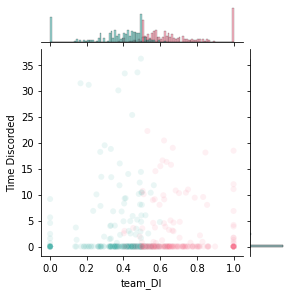

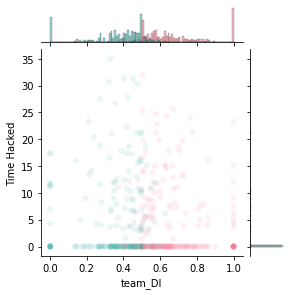

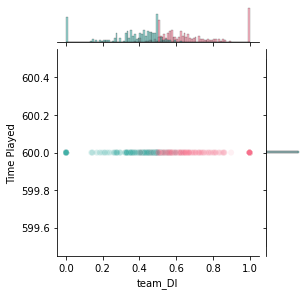

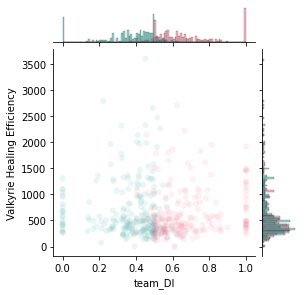

In [58]:
for stat in X.columns:
    g = sns.JointGrid(height=4)
    sns.scatterplot(x=y, y=X[stat], ax=g.ax_joint, hue=is_map_winner, palette='husl', legend=False, alpha=0.1)
    sns.histplot(x=y, ax=g.ax_marg_x, hue=is_map_winner, palette='husl', legend=False, alpha=0.5, bins=100)
    sns.histplot(y=X[stat], ax=g.ax_marg_y, hue=is_map_winner, palette='husl', legend=False, alpha=0.5, bins=100)

## 3. Regression Model

(371, 22) (93, 22) (371,) (93,)
22


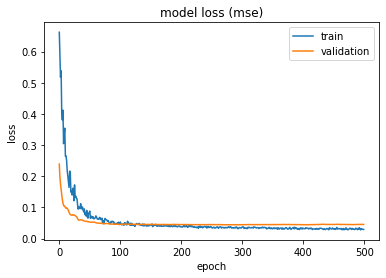

3/3 [==============================] - 0s 1ms/step - loss: 0.0476 - mae: 0.1619
evaluation: [0.047619059681892395, 0.16188447177410126]


In [59]:
# check input and target shape
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
num_input_node = X_train.shape[1]
print(num_input_node)

# Setup a model
model = Sequential()
# 1st layer
model.add(Dense(20, activation='relu', input_shape=(num_input_node,)))
model.add(Dropout(0.3))
# 2nd layer
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(1)) # No activation function because this is regression, not classification

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, validation_split=0.25, epochs=500, verbose=0) # set num of epochs

# Plot model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (mse)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Evaluate the model
evaluation = model.evaluate(x=X_test, y=y_test)
print(f'evaluation: {evaluation}')

In [60]:
from ann_visualizer.visualize import ann_viz

ann_viz(model, view=False, filename='network visualization/network.gv', title='Dominance Index regression network model')

Text(0.5, 0, 'Actual')

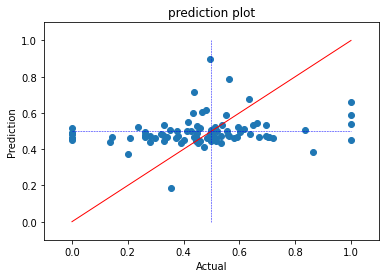

In [61]:
# plot predictions
y_pred = model.predict(X_test).flatten()
y_actual = y_test
plt.scatter(x=y_actual, y=y_pred)
plt.plot((0,1),(0,1), 'r', linewidth=1) # plot x=y line
plt.plot((0,1),(0.5,0.5), 'b--', linewidth=0.5) # plot grid
plt.plot((0.5,0.5),(0,1), 'b--', linewidth=0.5) # plot grid
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.title('prediction plot')
plt.ylabel('Prediction')
plt.xlabel('Actual')

## 4. SHAP interpretation

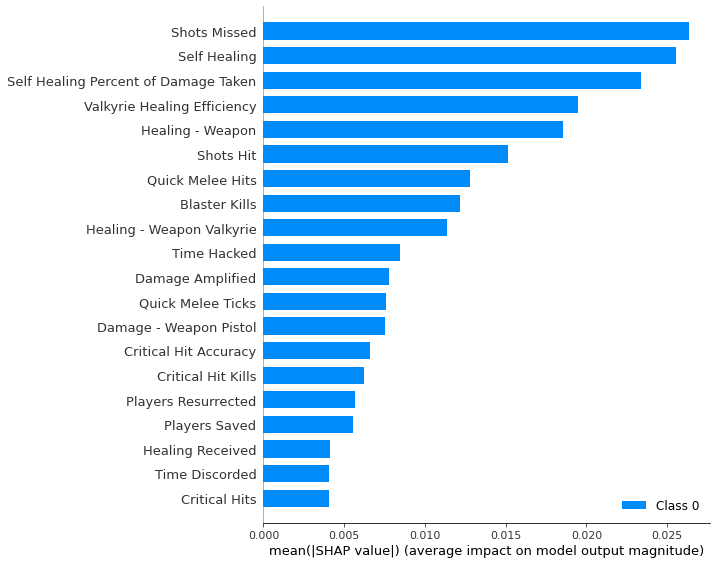

In [62]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model
explainer = shap.GradientExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

#
shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type='bar')

## Player's stat ranking

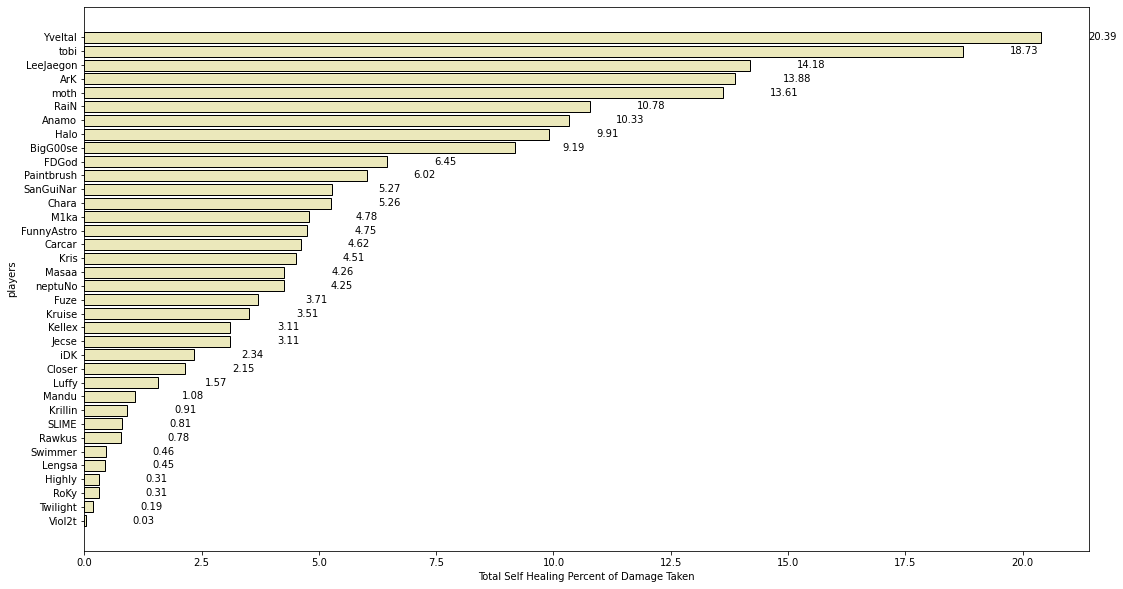

In [63]:
# player evaluation - stat ranking
target_stat = 'Self Healing Percent of Damage Taken'

df_player_stat = new_phs[['esports_match_id', 'player_name', 'team_name', 'map_name', 'stat_name', 'hero_name', 'stat_amount']]
df_player_stat = df_player_stat[df_player_stat['hero_name'] == target_hero]

df_player_stat = df_player_stat.groupby(['player_name', 'stat_name'])['stat_amount'].sum()
df_player_stat = df_player_stat.unstack()

df_player_stat_time_played = df_player_stat['Time Played'] # save hero time played as series

df_player_stat = df_player_stat[target_stat] # get selected feature
df_player_stat = pd.concat([df_player_stat, df_player_stat_time_played], axis=1)
df_player_stat.dropna(inplace=True)
df_player_stat[f'{target_stat}/10min'] = df_player_stat[target_stat].div(df_player_stat['Time Played'], axis=0) * 600

df_player_stat.sort_values(target_stat, inplace=True)
df_player_stat = df_player_stat.round(decimals=2)

plt.figure(figsize=(18,10))
plt.barh(df_player_stat.index.values, df_player_stat[target_stat], color=hero_hex_color.get(target_hero), edgecolor='black', linewidth=1, )
plt.ylabel('players')
plt.xlabel(f'Total {target_stat}')
for i in df_player_stat.index: # add values on bar graph
   plt.text(df_player_stat.loc[i, target_stat]+1, i, df_player_stat.loc[i, target_stat], 
   horizontalalignment='left', 
   verticalalignment='center')

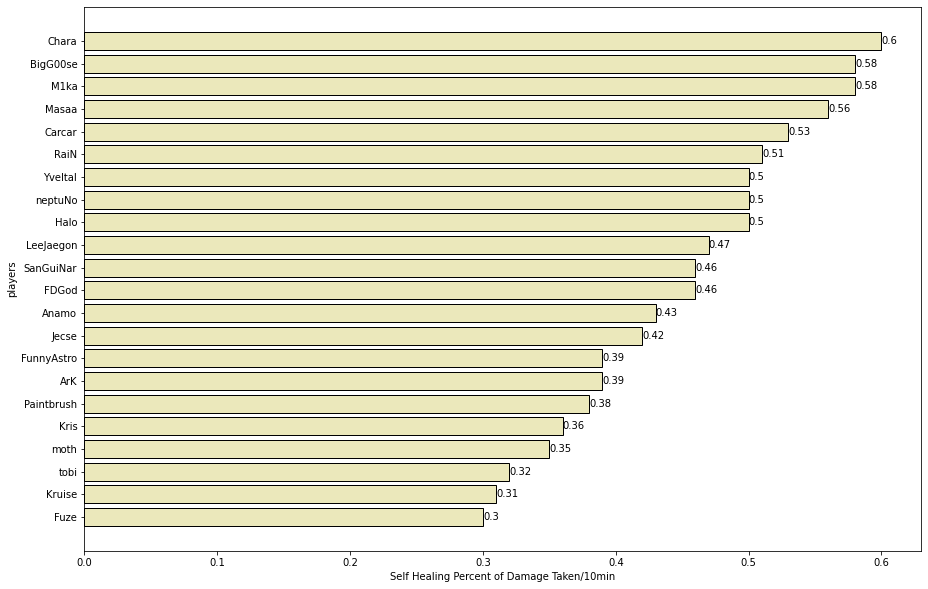

In [64]:
# for 10min stat
cut_time = 3600 # remove players who played less than cut_time
df_player_stat = df_player_stat[df_player_stat['Time Played'] >= cut_time]
df_player_stat.sort_values(f'{target_stat}/10min', inplace=True)

plt.figure(figsize=(15,10))
plt.barh(df_player_stat.index.values, df_player_stat[f'{target_stat}/10min'], color=hero_hex_color.get(target_hero), edgecolor='black', linewidth=1, )
plt.ylabel('players')
plt.xlabel(f'{target_stat}/10min')
for i in df_player_stat.index: # add values on bar graph
   plt.text(df_player_stat.loc[i, f'{target_stat}/10min'], i, df_player_stat.loc[i, f'{target_stat}/10min'], 
   horizontalalignment='left', 
   verticalalignment='center')